# Swin V2 Large

- loss: Binary Cross Entropy
- metrics: ROCAUC
- trainable: all
- CVあり
---
- label smoothing
- AugMix  
× CutMix  
× MixUp

## Load Model

In [1]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, get_cosine_schedule_with_warmup
import torch
from datasets import load_dataset

from utils.utils import load_img

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())

2.2.0.dev20230911+cu118
True
4
0
Tesla T4
(7, 5)


## 学習データの可視化

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# 食品と飲料をランダムに5個ずつ可視化する
df_train = pd.read_csv('train.csv')
df_train['num'] = df_train['image_name'].str[:-4].astype(int)

d_vis = df_train[df_train['label']==0].sample(5)['num'].tolist()
f_vis = df_train[df_train['label']==1].sample(5)['num'].tolist()

In [4]:
# データの偏り
print(f"N of drinks: {len(df_train[df_train['label']==0])}")
print(f"N of foods: {len(df_train[df_train['label']==1])}")

N of drinks: 994
N of foods: 1182


In [5]:
def show5img(ilist, stitle=None):
    n_cols = 5
    n_rows = (len(ilist)-1)//5+1
    
    fig = plt.figure(figsize=(n_cols*2, n_rows*2))
    for n, i in enumerate(ilist):
        ax = fig.add_subplot(n_rows, n_cols, n+1)
        im = load_img(i)
        im = np.asarray(im)
        ax.imshow(im)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.set_title(i)
    if stitle:
        fig.suptitle(stitle)
    fig.tight_layout()
    fig.show()

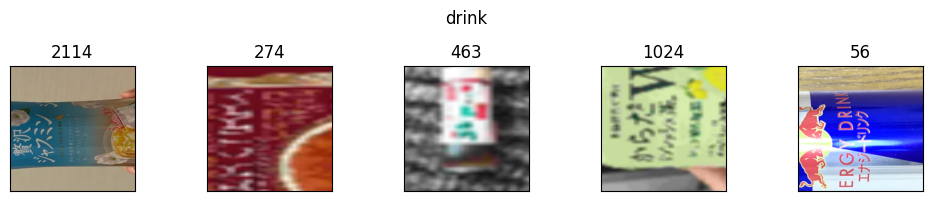

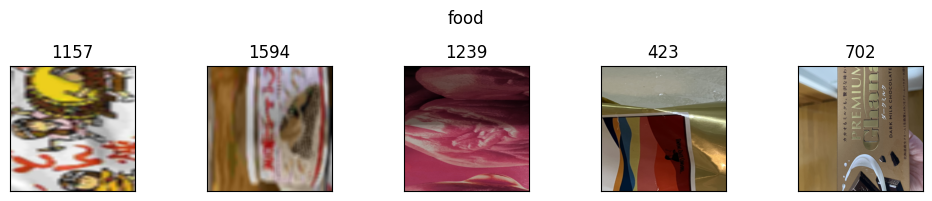

In [6]:
show5img(d_vis, stitle='drink')
show5img(f_vis, stitle='food')

## 転移学習/CV検証

In [7]:
import torch.nn as nn
from torchvision import transforms

from sklearn.model_selection import StratifiedKFold

In [8]:
device = torch.device('cuda')

データセット作成

In [9]:
# folding
n_folds = 5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)
df_train['fold'] = -1
for i, (_, val_idx) in enumerate(skf.split(df_train, df_train['label'])):
    df_train.loc[val_idx, 'fold'] = i

In [10]:
# label smoothing
df_train['label'] = df_train['label'].replace({0: 0.05, 1: 0.95})

In [11]:
df_train

,image_name,label,num,fold
0,0000.png,0.05,0,4
1,0001.png,0.95,1,2
2,0002.png,0.95,2,3
3,0003.png,0.95,3,0
4,0004.png,0.05,4,3
...,...,...,...,...
2171,2171.png,0.95,2171,3
2172,2172.png,0.95,2172,2
2173,2173.png,0.95,2173,3
2174,2174.png,0.05,2174,2


In [12]:
# テストデータ
df_test = pd.read_csv('sample_submit.csv', header=None)
df_test.columns = ['image_name', 'label']
df_test['num'] = df_test['image_name'].str[:-4].astype(int)
df_test['label'] = -1

In [13]:
df_test

,image_name,label,num
0,2176.png,-1,2176
1,2177.png,-1,2177
2,2178.png,-1,2178
3,2179.png,-1,2179
4,2180.png,-1,2180
...,...,...,...
2175,4351.png,-1,4351
2176,4352.png,-1,4352
2177,4353.png,-1,4353
2178,4354.png,-1,4354


In [14]:
train_transforms_1 = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomCrop(256),
        transforms.RandomCrop(384),
        transforms.RandomCrop(512),
    ]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply(
        [transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)],
        p=0.67,
    ),
    transforms.RandomApply(
        [transforms.GaussianBlur(3, sigma=(0.1, 2.0))],
        p=0.67,
    ),
    transforms.Resize((384, 384)),
    transforms.RandomApply(
        [transforms.RandomRotation(180)],
        p=0.5,
    ),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.33, scale=(0.02, 0.3)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_transforms_2 = transforms.Compose([
    transforms.AugMix(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


tta_transforms_1 = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomCrop(448),
        transforms.RandomCrop(512),
    ]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply(
        [transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)],
        p=0.67,
    ),
    transforms.RandomApply(
        [transforms.GaussianBlur(3, sigma=(0.1, 2.0))],
        p=0.67,
    ),
    transforms.Resize((384, 384)),
    # transforms.RandomApply(
    #     [transforms.RandomRotation(180)],
    #     p=0.5,
    # ),
    transforms.ToTensor(),
    # transforms.RandomErasing(p=0.33, scale=(0.02, 0.1)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

tta_transforms_2 = transforms.Compose([
    transforms.AugMix(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


data_transforms = {
    'train': transforms.RandomChoice([
        train_transforms_1, train_transforms_2
    ], p=[0.4, 0.6]),
    'valid': transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'tta': transforms.RandomChoice([
        tta_transforms_1, tta_transforms_2
    ], p=[0.5, 0.5])
}

In [15]:
# 例
def showTimg(n, phase='train'):
    image = load_img(0)
    image_t = data_transforms[phase](image)
    
    img1 = np.asarray(image)
    img2 = image_t.numpy().transpose((2,1,0))
    
    fig = plt.figure(figsize=(2*2, 1*2))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img1)
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)
    ax1.set_title(f'Raw_{n}')
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(img2)
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)
    ax2.set_title(f'Transformed_{n}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


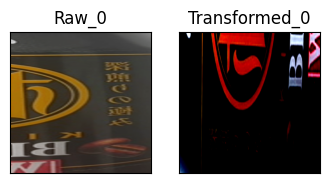

In [16]:
showTimg(0, phase='train')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


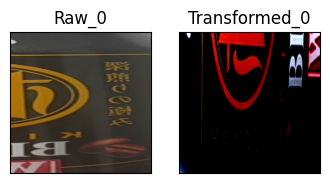

In [17]:
showTimg(0, phase='valid')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


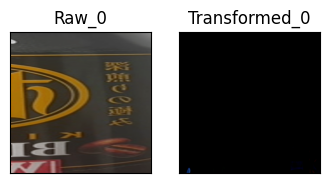

In [18]:
showTimg(0, phase='tta')

In [19]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform, tt='train'):
        if tt == 'train':
            self.dir = 'train/'
        elif tt == 'test':
            self.dir = 'test/'
        
        self.df = df
        self.transform = transform
        self.labels = np.expand_dims(df['label'].values, 1)
        self.labels = self.labels.astype(float)

    # len()を使用すると呼ばれる
    def __len__(self):
        return len(self.labels)

    # 要素を参照すると呼ばれる関数    
    def __getitem__(self, idx):
        num = self.df['num'].values[idx]
        image = load_img(num)
        image = self.transform(image)
        return image, self.labels[idx]

In [20]:
def foldData(fold, bs=32):
    df_train_ = df_train[df_train['fold']!=fold]
    df_valid_ = df_train[df_train['fold']==fold]
    df_test_ = df_test
    
    image_datasets = {
        'train': MyDataset(df_train_, data_transforms['train'], tt='train'),
        'valid': MyDataset(df_valid_, data_transforms['valid'], tt='train'),
        'vta': MyDataset(df_valid_, data_transforms['tta'], tt='train'),
        'test': MyDataset(df_test_, data_transforms['valid'], tt='test'),
        'tta': MyDataset(df_test_, data_transforms['tta'], tt='test'),
    }
    
    dataloaders = {
        'train': torch.utils.data.DataLoader(image_datasets['train'],
                                             batch_size=bs, shuffle=True, num_workers=16, pin_memory=True),
        'valid': torch.utils.data.DataLoader(image_datasets['valid'],
                                             batch_size=32, shuffle=False, num_workers=16, pin_memory=True),
        'vta': torch.utils.data.DataLoader(image_datasets['vta'],
                                           batch_size=32, shuffle=False, num_workers=16, pin_memory=True),
        'test': torch.utils.data.DataLoader(image_datasets['test'],
                                            batch_size=32, shuffle=False, num_workers=16, pin_memory=True),
        'tta': torch.utils.data.DataLoader(image_datasets['tta'],
                                           batch_size=32, shuffle=False, num_workers=16, pin_memory=True),
    }
    
#     return train_idx, valid_idx, image_datasets, dataloaders
    return image_datasets, dataloaders

モデル構築

In [21]:
from torcheval.metrics import BinaryAUROC
import torch.optim as optim
from torcheval.metrics.functional import binary_auroc

In [22]:
def loadNewModel():
    m = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-large-patch4-window12to24-192to384-22kto1k-ft")
    m.classifier = nn.Linear(1536, 1, bias=True)
    m = torch.nn.DataParallel(m, device_ids=[0, 1, 2, 3]) # make parallel
    m.to(device)
    for p in m.parameters():
        p.requires_grad = False
    return m

学習

In [23]:
import copy, time
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.transforms import v2

In [24]:
scaler = torch.cuda.amp.GradScaler()

In [25]:
def train(model, criterion, optimizer, scheduler, image_datasets, dataloaders, epochs=5):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc = 0.0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs-1}')
        print('-' * 10)
        
        for phase in ('train', 'valid'):
            if phase == 'train':
                is_train = True
                model.train()  # Set model to training mode
            else:
                is_train = False
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_auc = 0.0
            
            # イタレーション
            for b, (inputs, labels) in enumerate(dataloaders[phase]):
                print(f'\rBatch: {b}/{len(image_datasets[phase])//dataloaders[phase].batch_size} ({phase})', end="")
                # images, labels = cutmix_or_mixup(images, labels)
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(is_train):
                    with torch.cuda.amp.autocast(): 
                        outputs = model(inputs).logits
                        # loss = criterion(torch.flatten(outputs), torch.flatten(labels))
                        loss = criterion(outputs, labels)
                    auc = binary_auroc(torch.flatten(torch.sigmoid(outputs)),
                                       torch.flatten(labels))

                    # backward + optimize only if in training phase
                    if is_train:
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update() 

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_auc +=  auc * inputs.size(0)
                
                del loss, auc, labels, inputs, outputs
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_auc = running_auc / len(image_datasets[phase])
            
            print()
            print(f'{phase} Loss: {epoch_loss:.4f} AUC: {epoch_auc:.4f}')
            
            # deep copy the model
            if phase == 'valid' and epoch_auc > best_auc:
                best_auc = epoch_auc
                best_model_wts = copy.deepcopy(model.state_dict())
            del epoch_loss, epoch_auc, running_loss, running_auc
            torch.cuda.empty_cache()
            
        scheduler.step()
        print()
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val AUC: {best_auc:.4f}')
    print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    del best_model_wts
    return model

- 通常の代入とTTAで比較

In [26]:
def valid(model, dataloader):
    noutputs = []
    nlabels = []
    for b, (inputs, labels) in enumerate(dataloader):
        print(f'\rBatch: {b}/{len(dataloader.dataset)//dataloader.batch_size}', end="")
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            noutputs.append(model(inputs).logits)
            nlabels.append(labels)
        del inputs, labels
    alloutputs = torch.cat(noutputs)
    alllabels = torch.cat(nlabels)
    
    preds = torch.sigmoid(torch.flatten(alloutputs))
    auc = binary_auroc(preds, torch.flatten(alllabels))
    print()
    print()
    print(f'AUC: {auc:.4f}')
    
    return preds.cpu().detach().numpy()

In [27]:
def tta(model, dataloader, n=5):
    alloutputs = []
    
    for i in range(n):
        print(f'n: {i}/{n-1}')
        print('-' * 10)
        noutputs = []
        nlabels = []
        for b, (inputs, labels) in enumerate(dataloader):
            print(f'\rBatch: {b}/{len(dataloader.dataset)//dataloader.batch_size}', end="")
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                noutputs.append(model(inputs).logits)
                nlabels.append(labels)
            del inputs, labels
        alloutputs.append(torch.cat(noutputs))
        alllabels = torch.cat(nlabels)
        print()
    alloutputs = torch.cat(alloutputs, 1)
    preds = torch.sigmoid(torch.mean(alloutputs, dim=1))
    auc = binary_auroc(preds, torch.flatten(alllabels))
    print()
    print(f'AUC: {auc:.4f}')
    
    return preds.cpu().detach().numpy()

In [28]:
def valMix(model, dataloaders, n=5, mode='valid'):
    # 通常valid
    print(f"=== Normal {'Valid' if mode=='valid' else 'Test'} ===")
    if mode =='valid':
        dataloader = dataloaders['valid']
    elif mode == 'test':
        dataloader = dataloaders['test']
    noutputs = []
    nlabels = []
    for b, (imgs, labels) in enumerate(dataloader):
        print(f'\rBatch: {b}/{len(dataloader.dataset)//dataloader.batch_size}', end="")
        inputs = imgs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            noutputs.append(model(inputs).logits)
            nlabels.append(labels)
    alloutputs = torch.cat(noutputs)
    alllabels = torch.cat(nlabels)
    
    preds1 = torch.sigmoid(torch.flatten(alloutputs))
    auc = binary_auroc(preds1, torch.flatten(alllabels))
    print()
    print()
    print(f'Norml Valid AUC: {auc:.4f}')
    print()
    
    # TTA valid
    print(f"=== {'Valid' if mode=='valid' else 'Test'} Time Augmentation ===")
    if mode =='valid':
        dataloader = dataloaders['vta']
    elif mode == 'test':
        dataloader = dataloaders['tta']
    alloutputs = [alloutputs]
    
    for i in range(n):
        print(f'n: {i}/{n-1}')
        print('-' * 10)
        noutputs = []
        for b, (imgs, labels) in enumerate(dataloader):
            print(f'\rBatch: {b}/{len(dataloader.dataset)//dataloader.batch_size}', end="")
            inputs = imgs.to(device)
            with torch.no_grad():
                noutputs.append(model(inputs).logits)
        alloutputs.append(torch.cat(noutputs))
        print()
    alloutputs = torch.cat(alloutputs, 1)
    preds2 = torch.sigmoid(torch.mean(alloutputs, dim=1))
    auc = binary_auroc(preds2, torch.flatten(alllabels))
    print()
    print(f'VTA AUC: {auc:.4f}')
    print()
    
    # Mix
    print('=== Mixed Valid ===')
    preds1to0 = preds1 - 0
    preds1to1 = 1 - preds1
    preds2to0 = preds2 - 0
    preds2to1 = 1 - preds2
    
    stack = torch.stack([preds1to0, preds1to1, preds2to0, preds2to1])
    pstack = torch.stack([preds1, preds1, preds2, preds2])
    
    argmin = torch.argmin(stack, dim=0)
    preds = torch.diag(pstack[argmin])
    auc = binary_auroc(preds, torch.flatten(alllabels))
    print()
    print(f'Mixed AUC: {auc:.4f}')
    return preds1.cpu().detach().numpy(), preds2.cpu().detach().numpy(), preds.cpu().detach().numpy()

### CV

In [29]:
from numba import cuda

In [30]:
### 検証時のAugmentation
n_vta = 5

In [31]:
### パラメータ変更可能な部分 ###
"""
  model.module.swinv2.embeddings

  model.module.swinv2.encoder.layers[0]
  -> model.module.swinv2.encoder.layers[0].blocks[0] ~ [1]

  model.module.swinv2.encoder.layers[1]
  -> model.module.swinv2.encoder.layers[1].blocks[0] ~ [1]

  model.module.swinv2.encoder.layers[2]
  -> model.module.swinv2.encoder.layers[2].blocks[0] ~ [17]

  model.module.swinv2.encoder.layers[3]
  -> model.module.swinv2.encoder.layers[3].blocks[0] ~ [1]

  model.module.swinv2.layernorm
  
  (model.module.swinv2.pooler)

  model.module.classifier
"""

'\n  model.module.swinv2.embeddings\n\n  model.module.swinv2.encoder.layers[0]\n  -> model.module.swinv2.encoder.layers[0].blocks[0] ~ [1]\n\n  model.module.swinv2.encoder.layers[1]\n  -> model.module.swinv2.encoder.layers[1].blocks[0] ~ [1]\n\n  model.module.swinv2.encoder.layers[2]\n  -> model.module.swinv2.encoder.layers[2].blocks[0] ~ [17]\n\n  model.module.swinv2.encoder.layers[3]\n  -> model.module.swinv2.encoder.layers[3].blocks[0] ~ [1]\n\n  model.module.swinv2.layernorm\n  \n  (model.module.swinv2.pooler)\n\n  model.module.classifier\n'

In [32]:
specs = [
    {
        'bs': 32,
        'trainLayers': 1,
        'lr': 1e-3,
        'epochs': 15,
        'num_warmup_steps': 5,  # CosSchWarm
        'num_training_steps': 20,  # CosSchWarm
        'num_cycles': 0.5,  # CosSchWarm
    },
    {
        'bs': 32,
        'trainLayers': 2,
        'lr': 1e-3,
        'epochs': 15,
        'num_warmup_steps': 5,  # CosSchWarm
        'num_training_steps': 20,  # CosSchWarm
        'num_cycles': 0.5,  # CosSchWarm
    },
    {
        'bs': 32,
        'trainLayers': 3,
        'lr': 5e-4,
        'epochs': 30,
        'num_warmup_steps': 5,  # CosSchWarm
        'num_training_steps': 35,  # CosSchWarm
        'num_cycles': 1.5,  # CosSchWarm
    },
    {
        'bs': 24,
        'trainLayers': 4,
        'lr': 1e-4,
        'epochs': 100,
        'num_warmup_steps': 10,  # CosSchWarm
        'num_training_steps': 105,  # CosSchWarm
        'num_cycles': 4.5,  # CosSchWarm
    },
]

In [33]:
vals = {}
vtas = {}
mixs = {}

In [34]:
torch.backends.cudnn.benchmark = True

In [35]:
def train_spec(fold, i, model_path='model.pth'):
    spec = specs[i]
    
    # datasetsを作る
    image_datasets, dataloaders = foldData(fold, bs=spec['bs'])
    
    # 新しいモデルを読み込み
    if i == 0:
        model = loadNewModel()
    else:
        model = torch.load(model_path)
        model.to(device)
        for p in model.parameters():
            p.requires_grad = False
    
    layer_list = [
        model.module.classifier,
        model.module.swinv2.layernorm,
        model.module.swinv2.encoder.layers[3],
        model.module.swinv2.encoder.layers[2],
    ]
    
    for j in range(spec['trainLayers']):
        layer = layer_list[j]
        for p in layer.parameters():
            p.requires_grad = True
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=None)
    if False:
    # if i < len(specs)-2:
        optimizer = optim.SGD(model.parameters(), lr=spec['lr'], momentum=0.9)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=spec['sch_steps'], gamma=spec['sch_gamma'])
    else:
        optimizer = optim.AdamW(model.parameters(), lr=spec['lr'])
        lr_scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                       num_warmup_steps=spec['num_warmup_steps'],
                                                       num_training_steps=spec['num_training_steps'],
                                                       num_cycles=spec['num_cycles'])
    
    model = train(model, criterion, optimizer, lr_scheduler, image_datasets, dataloaders,
                  epochs=spec['epochs'])
    
    torch.save(model, model_path)
    del model
    torch.cuda.empty_cache()

In [36]:
def fold_train(fold):
    print(f'=== Fold: {fold} ===')
    print('GPU Memory:', torch.cuda.memory_allocated())
    
    for i in range(len(specs)):
        print(f'<< Spec: {i} >>')
        train_spec(fold, i)
    
    print('- Validation -')
    model = torch.load('model.pth')
    model.to(device)
    
    image_datasets, dataloaders = foldData(fold)
    
    val, vta, mix = valMix(model, dataloaders, n=n_vta)
    vals[fold] = val
    vtas[fold] = vta
    mixs[fold] = mix
    
    print()
    
    torch.save(model, f'model_{fold}.pth')
    
    del model
    torch.cuda.empty_cache()

In [ ]:
%%capture cap

for fold in range(n_folds):
    fold_train(fold)

with open('log_train.txt', 'w') as f:
    f.write(cap.stdout)

In [39]:
cap()

=== Fold: 0 ===
GPU Memory: 0
<< Spec: 0 >>
Epoch 0/14
----------
Batch: 54/54 (train)
train Loss: 0.7414 AUC: 0.4412
Batch: 13/13 (valid)
valid Loss: 0.7342 AUC: 0.4519

Epoch 1/14
----------
Batch: 54/54 (train)
train Loss: 0.6785 AUC: 0.5961
Batch: 13/13 (valid)
valid Loss: 0.6100 AUC: 0.7315

Epoch 2/14
----------
Batch: 54/54 (train)
train Loss: 0.6042 AUC: 0.7303
Batch: 13/13 (valid)
valid Loss: 0.5485 AUC: 0.7947

Epoch 3/14
----------
Batch: 54/54 (train)
train Loss: 0.5811 AUC: 0.7557
Batch: 13/13 (valid)
valid Loss: 0.5259 AUC: 0.8099

Epoch 4/14
----------
Batch: 54/54 (train)
train Loss: 0.5672 AUC: 0.7768
Batch: 13/13 (valid)
valid Loss: 0.5114 AUC: 0.8237

Epoch 5/14
----------
Batch: 54/54 (train)
train Loss: 0.5428 AUC: 0.7955
Batch: 13/13 (valid)
valid Loss: 0.4955 AUC: 0.8363

Epoch 6/14
----------
Batch: 54/54 (train)
train Loss: 0.5238 AUC: 0.8146
Batch: 13/13 (valid)
valid Loss: 0.4872 AUC: 0.8428

Epoch 7/14
----------
Batch: 54/54 (train)
train Loss: 0.5223 AUC: 

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [40]:
print(torch.cuda.memory_allocated())

17957888


## 推論・提出

In [41]:
df_submit = df_test[['image_name', 'label']].copy()

In [42]:
def predictCV(fold):
    model = torch.load(f'model_{fold}.pth')
    model.to(device)
    
    _, dataloaders = foldData(fold)
    test, tta, tmix = valMix(model, dataloaders, n=5, mode='test')
    
    df_submit[f'label_test_{fold}'] = test
    df_submit[f'label_tta_{fold}'] = tta
    df_submit[f'label_tmix_{fold}'] = tmix
    
    del model
    torch.cuda.empty_cache()

In [43]:
for fold in range(n_folds):
    predictCV(fold)

=== Normal Test ===


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Batch: 68/68

Norml Valid AUC: 0.5000

=== Test Time Augmentation ===
n: 0/4
----------
Batch: 68/68
n: 1/4
----------
Batch: 68/68
n: 2/4
----------
Batch: 68/68
n: 3/4
----------
Batch: 68/68
n: 4/4
----------
Batch: 68/68

VTA AUC: 0.5000

=== Mixed Valid ===

Mixed AUC: 0.5000
=== Normal Test ===


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Batch: 68/68

Norml Valid AUC: 0.5000

=== Test Time Augmentation ===
n: 0/4
----------
Batch: 68/68
n: 1/4
----------
Batch: 68/68
n: 2/4
----------
Batch: 68/68
n: 3/4
----------
Batch: 68/68
n: 4/4
----------
Batch: 68/68

VTA AUC: 0.5000

=== Mixed Valid ===

Mixed AUC: 0.5000
=== Normal Test ===


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Batch: 68/68

Norml Valid AUC: 0.5000

=== Test Time Augmentation ===
n: 0/4
----------
Batch: 68/68
n: 1/4
----------
Batch: 68/68
n: 2/4
----------
Batch: 68/68
n: 3/4
----------
Batch: 68/68
n: 4/4
----------
Batch: 68/68

VTA AUC: 0.5000

=== Mixed Valid ===

Mixed AUC: 0.5000
=== Normal Test ===


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Batch: 68/68

Norml Valid AUC: 0.5000

=== Test Time Augmentation ===
n: 0/4
----------
Batch: 68/68
n: 1/4
----------
Batch: 68/68
n: 2/4
----------
Batch: 68/68
n: 3/4
----------
Batch: 68/68
n: 4/4
----------
Batch: 68/68

VTA AUC: 0.5000

=== Mixed Valid ===

Mixed AUC: 0.5000
=== Normal Test ===


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Batch: 68/68

Norml Valid AUC: 0.5000

=== Test Time Augmentation ===
n: 0/4
----------
Batch: 68/68
n: 1/4
----------
Batch: 68/68
n: 2/4
----------
Batch: 68/68
n: 3/4
----------
Batch: 68/68
n: 4/4
----------
Batch: 68/68

VTA AUC: 0.5000

=== Mixed Valid ===

Mixed AUC: 0.5000


In [44]:
# 平均対象を抽出して提出
targ = 'tmix'

mean = df_submit[[f'label_{targ}_{fold}' for fold in range(n_folds)]].mean(axis=1)
df_submit['label'] = mean

df_submit[['image_name', 'label']].to_csv('submit.csv', header=None, index=None)

In [45]:
df_submit.to_csv('model_v3-cv.csv', index=False)

提出

In [46]:
%%bash
signate submit --competition-id=1106 submit.csv --note model3_CV_tmix

You have successfully submitted your predictions.We will send you the submission result to your email address.


model_v2とアンサンブル

In [57]:
df_1 = pd.read_csv('model_v2-cv.csv')
df_2 = pd.read_csv('model_v3-cv.csv')

In [62]:
targ = 'tmix'

mean1 = df_1[[f'label_{targ}_{fold}' for fold in range(5)]].mean(axis=1)
mean2 = df_2[[f'label_{targ}_{fold}' for fold in range(5)]].mean(axis=1)
mean = (mean1 + mean2) / 2

In [67]:
df_submit = df_1[['image_name', 'label']].copy()
df_submit['label'] = mean
df_submit.to_csv('submit.csv', header=None, index=None)

In [68]:
%%bash
signate submit --competition-id=1106 submit.csv --note model2CVtmix_model3CVtmix

You have successfully submitted your predictions.We will send you the submission result to your email address.
